# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from joblib import dump, load

# EDA

## Load Data

In [2]:
df = pd.read_csv('data/BMRI_mult.csv', sep=';')
df = df.reindex(index=df.index[::-1])

df.head()

,Date,Price,Open,High,Low,Vol,Change
1459,12/03/2018,7600,7550,7725,7550,68.34M,2.70%
1458,12/04/2018,7650,7575,7650,7550,30.08M,0.66%
1457,12/05/2018,7575,7600,7600,7525,36.66M,-0.98%
1456,12/06/2018,7475,7400,7525,7400,37.05M,-1.32%
1455,12/07/2018,7500,7575,7625,7475,20.85M,0.33%


## Info Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 1459 to 0
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1460 non-null   object
 1   Price   1460 non-null   int64 
 2   Open    1460 non-null   int64 
 3   High    1460 non-null   int64 
 4   Low     1460 non-null   int64 
 5   Vol     1460 non-null   object
 6   Change  1460 non-null   object
dtypes: int64(4), object(3)
memory usage: 80.0+ KB


## Null Value

In [4]:
df.isnull().sum()

Date      0
Price     0
Open      0
High      0
Low       0
Vol       0
Change    0
dtype: int64

## Set date format

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, format='%m/%d/%Y').dt.date
df['Change'] = df['Change'].str.replace('%', '').str.replace(',', '.').astype(float)
df['Change'] = df['Change'].astype(float)
df['Vol'] = df['Vol'].str.replace('M', 'e6').str.replace('B', 'e9').str.replace(',', '.').astype(float)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

,Price,Open,High,Low,Vol,Change
Date,,,,,,
2018-12-03,7600,7550,7725,7550,68340000.0,2.70
2018-12-04,7650,7575,7650,7550,30080000.0,0.66
2018-12-05,7575,7600,7600,7525,36660000.0,-0.98
2018-12-06,7475,7400,7525,7400,37050000.0,-1.32
2018-12-07,7500,7575,7625,7475,20850000.0,0.33
...,...,...,...,...,...,...
2024-12-02,6000,6175,6250,5975,114560000.0,-2.44
2024-12-03,6275,6100,6275,6100,99510000.0,4.58
2024-12-04,6375,6275,6450,6225,75260000.0,1.59


## Plot Data

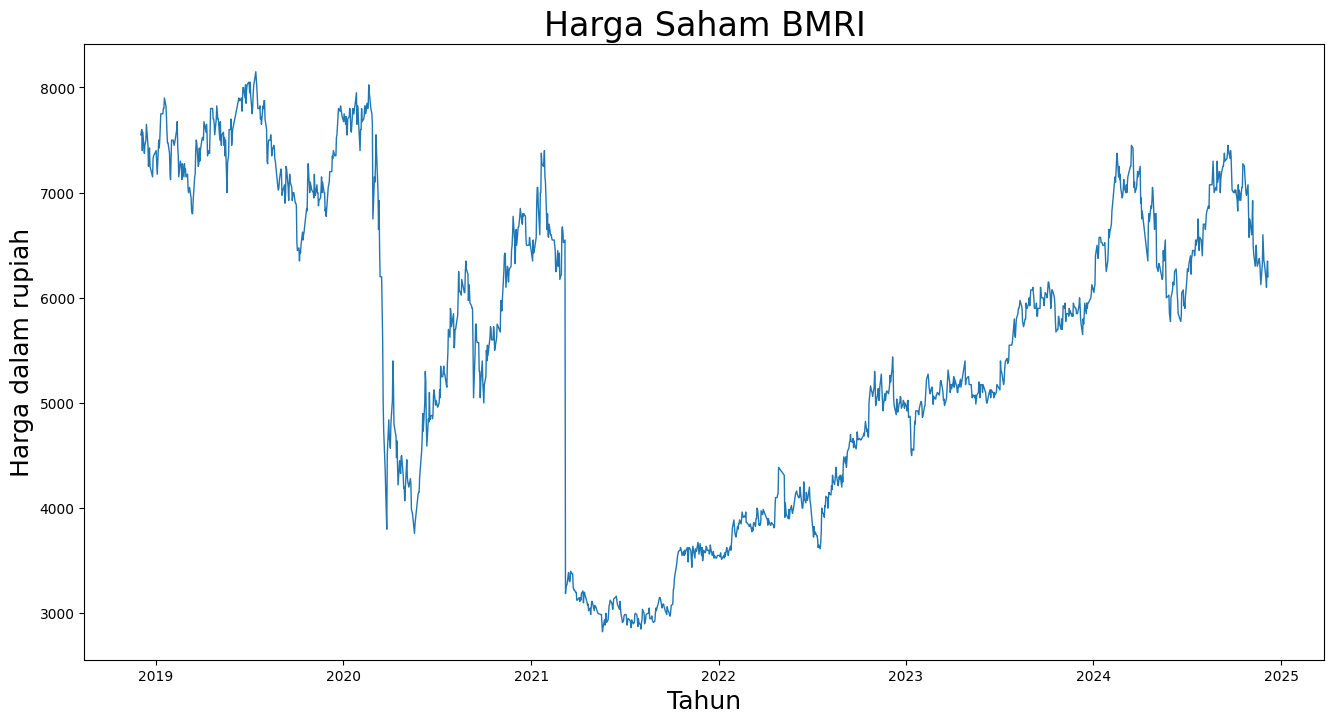

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga dalam rupiah', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#2419ef", "#19c4ef", "#EF5919"])
sns.lineplot(x='Date', y='Open', data=df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

## Histogram Data

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>, <Axes: title={'center': 'Vol'}>],
       [<Axes: title={'center': 'Change'}>, <Axes: >]], dtype=object)

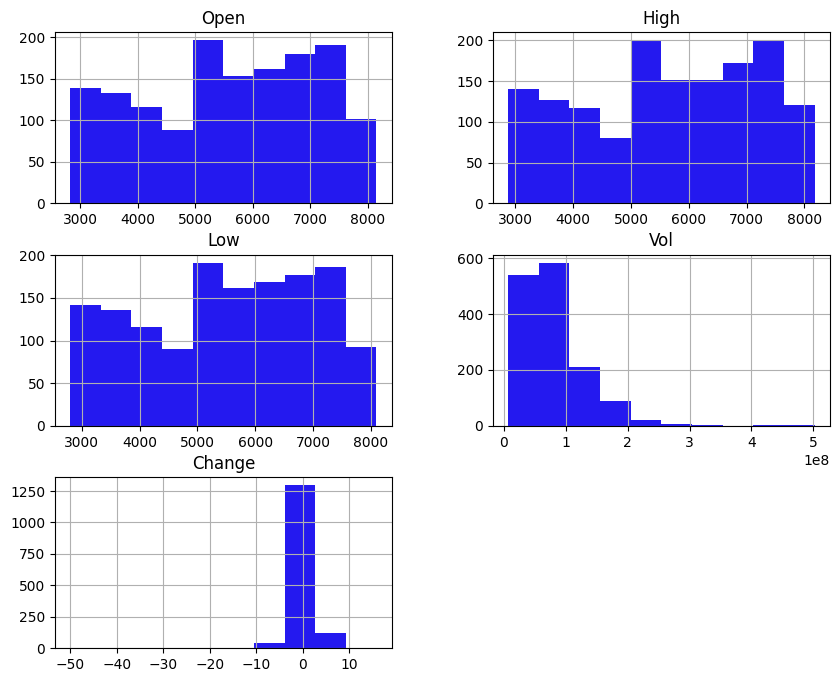

In [7]:
df.hist(figsize=(10, 8), column=['Open', 'High', 'Low', 'Vol', 'Change'])

## Boxplot Data

<Axes: >

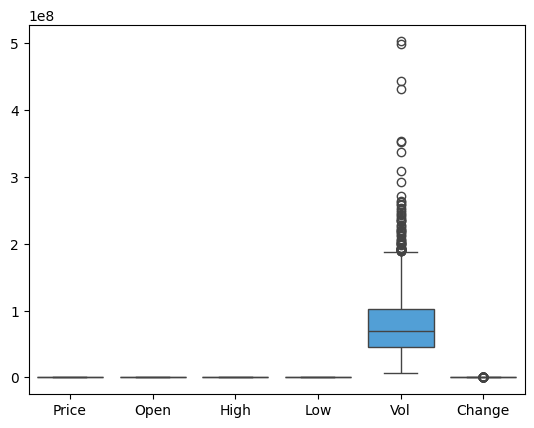

In [8]:
sns.boxplot(data=df)

## Corellation Matrix

           Price      Open      High       Low       Vol    Change
Price   1.000000  0.997671  0.998930  0.998896 -0.262281  0.036160
Open    0.997671  1.000000  0.998872  0.998815 -0.263644 -0.010878
High    0.998930  0.998872  1.000000  0.998448 -0.253346  0.012897
Low     0.998896  0.998815  0.998448  1.000000 -0.270512  0.012472
Vol    -0.262281 -0.263644 -0.253346 -0.270512  1.000000  0.016278
Change  0.036160 -0.010878  0.012897  0.012472  0.016278  1.000000


<Axes: >

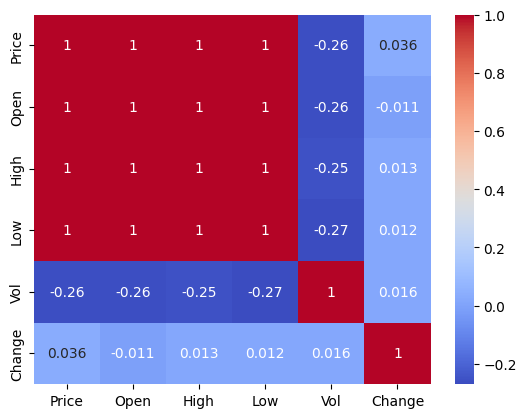

In [9]:
correlation_matrix = df.corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Prepocessing
## Select Feature

In [10]:
selected_features = ['Price', 'Open', 'High', 'Low']
df = df[selected_features]
df

,Price,Open,High,Low
Date,,,,
2018-12-03,7600,7550,7725,7550
2018-12-04,7650,7575,7650,7550
2018-12-05,7575,7600,7600,7525
2018-12-06,7475,7400,7525,7400
2018-12-07,7500,7575,7625,7475
...,...,...,...,...
2024-12-02,6000,6175,6250,5975
2024-12-03,6275,6100,6275,6100
2024-12-04,6375,6275,6450,6225


In [11]:
def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
    csv = {
        'Date': data.index,
        'Open': data['Open'].values,
        'normalized_Pembukaan': normalized_data['Open'].values
        
    }
    csv = pd.DataFrame(csv)
    return normalized_data, scaler, csv


normalized_df, scaler, csv_normalized = normalize_data(df)
csv_normalized.to_csv('normalized_data.csv', index=False)
dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [12]:
normalized_df

,Price,Open,High,Low
Date,,,,
2018-12-03,0.896714,0.887324,0.915094,0.896226
2018-12-04,0.906103,0.892019,0.900943,0.896226
2018-12-05,0.892019,0.896714,0.891509,0.891509
2018-12-06,0.873239,0.859155,0.877358,0.867925
2018-12-07,0.877934,0.892019,0.896226,0.882075
...,...,...,...,...
2024-12-02,0.596244,0.629108,0.636792,0.599057
2024-12-03,0.647887,0.615023,0.641509,0.622642
2024-12-04,0.666667,0.647887,0.674528,0.646226


In [13]:
def denormalize_data(data, scaler):
    return pd.DataFrame(scaler.inverse_transform(data), columns=data.columns, index=data.index)

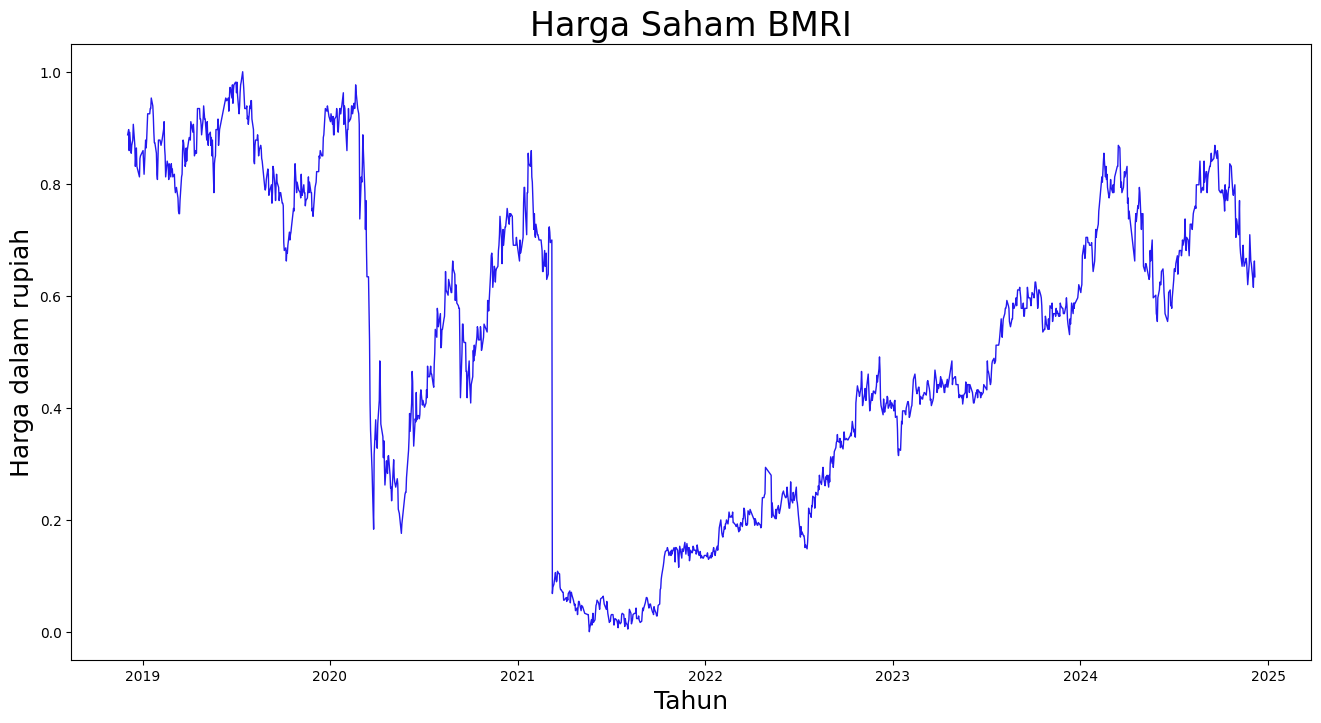

In [14]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga dalam rupiah', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#2419ef", "#19c4ef", "#EF5919"])
sns.lineplot(x='Date', y='Open', data=normalized_df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

## Create Data Lag

In [15]:
def sliding_windows(data, lags=3):
    lagged_data = data.copy()
    for lag in range(1, lags + 1):
        lagged_data[[f"{col}_lag{lag}" for col in data.columns]] = data.shift(lag)
    lagged_data.dropna(inplace=True)
    return lagged_data

lags = 30 * 12
windowed_data = sliding_windows(normalized_df, lags)

windowed_data.to_csv('./lagged_data.csv')

C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1057553649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[[f"{col}_lag{lag}" for col in data.columns]] = data.shift(lag)
C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1057553649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[[f"{col}_lag{lag}" for col in data.columns]] = data.shift(lag)
C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1057553649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1057553649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[[f"{col}_lag{lag}" for col in data.columns]] = data.shift(lag)
C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1057553649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_data[[f"{col}_lag{lag}" for col in data.columns]] = data.shift(lag)
C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1057553649.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [16]:
windowed_data

,Price,Open,High,Low,Price_lag1,Open_lag1,High_lag1,Low_lag1,Price_lag2,Open_lag2,...,High_lag358,Low_lag358,Price_lag359,Open_lag359,High_lag359,Low_lag359,Price_lag360,Open_lag360,High_lag360,Low_lag360
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-27,0.241315,0.248826,0.250000,0.228302,0.239437,0.245070,0.242453,0.237736,0.233803,0.192488,...,0.891509,0.891509,0.906103,0.892019,0.900943,0.896226,0.896714,0.887324,0.915094,0.896226
2020-05-28,0.275117,0.248826,0.276415,0.254717,0.241315,0.248826,0.250000,0.228302,0.239437,0.245070,...,0.877358,0.867925,0.892019,0.896714,0.891509,0.891509,0.906103,0.892019,0.900943,0.896226
2020-05-29,0.308920,0.275117,0.304717,0.273585,0.275117,0.248826,0.276415,0.254717,0.241315,0.248826,...,0.896226,0.882075,0.873239,0.859155,0.877358,0.867925,0.892019,0.896714,0.891509,0.891509
2020-06-02,0.337089,0.323944,0.399057,0.326415,0.308920,0.275117,0.304717,0.273585,0.275117,0.248826,...,0.877358,0.858491,0.877934,0.892019,0.896226,0.882075,0.873239,0.859155,0.877358,0.867925
2020-06-03,0.382160,0.346479,0.391509,0.337736,0.337089,0.323944,0.399057,0.326415,0.308920,0.275117,...,0.867925,0.867925,0.863850,0.854460,0.877358,0.858491,0.877934,0.892019,0.896226,0.882075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,0.596244,0.629108,0.636792,0.599057,0.624413,0.657277,0.660377,0.627358,0.680751,0.661972,...,0.415094,0.415094,0.417840,0.417840,0.419811,0.405660,0.422535,0.427230,0.429245,0.429245
2024-12-03,0.647887,0.615023,0.641509,0.622642,0.596244,0.629108,0.636792,0.599057,0.624413,0.657277,...,0.415094,0.415094,0.413146,0.408451,0.415094,0.415094,0.417840,0.417840,0.419811,0.405660
2024-12-04,0.666667,0.647887,0.674528,0.646226,0.647887,0.615023,0.641509,0.622642,0.596244,0.629108,...,0.424528,0.415094,0.413146,0.408451,0.415094,0.415094,0.413146,0.408451,0.415094,0.415094


## Split Data

In [17]:
input_df = windowed_data.drop(columns=['Price', 'Open', 'High', 'Low'])
target_df = windowed_data[['Open']]

x_train, x_test, y_train, y_test = train_test_split(input_df, target_df, test_size=0.2)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)




X_train shape: (880, 1440)
y_train shape: (880, 1)
X_test shape: (220, 1440)
y_test shape: (220, 1)


# Modelling

## Modelling Data

In [18]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

bagging_model = BaggingRegressor(estimator=LinearRegression(), n_estimators=100, random_state=42, n_jobs=-1)
bagging_model.fit(x_train, y_train.values.ravel())

y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAPE: {mape}')

MSE: 0.0005362244807351434
MAPE: 0.13572903867544875


In [19]:
dump(linear_model, 'bagging_linear.lib')

['bagging_linear.lib']

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.0005362244807351434
Mean Absolute Error (MAE): 0.01758126603973969
Mean Absolute Percentage Error (MAPE): 0.13572903867544875
R-squared (R2): 0.9909392740260989


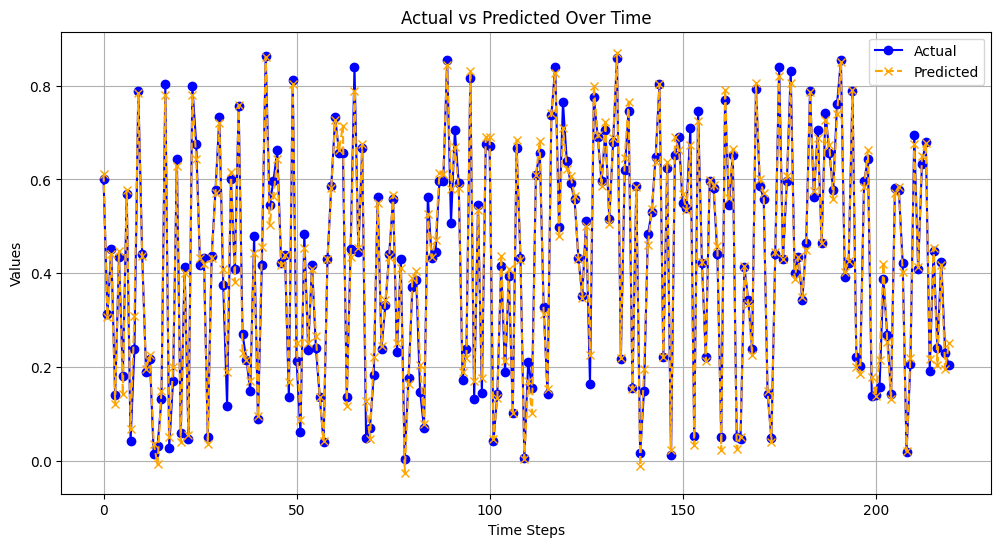

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker="o", linestyle="-", color="blue")
plt.plot(bagging_model.predict(x_test), label="Predicted", marker="x", linestyle="--", color="orange")
plt.title("Actual vs Predicted Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

# Testing

In [22]:
def multistep_forecast(model, data, n_steps):
  forecast = []
  last_observation = data.iloc[-1].values.reshape(1, -1)
  
  for _ in range(n_steps):
    next_step = model.predict(last_observation)
    forecast.append(next_step[0])
    
    # Update the last observation with the new prediction
    last_observation = np.roll(last_observation, -1)
    last_observation[0, -1] = next_step[0]
  
  return forecast

# Number of steps to forecast
n_steps = 30 * 12

# Perform the forecast
forecasted_values = multistep_forecast(linear_model, input_df, n_steps)
print(forecasted_values)

[array([0.63380282]), array([0.6410225]), array([0.6374315]), array([0.70060188]), array([0.65678434]), array([0.6400236]), array([0.63657141]), array([0.67477599]), array([0.65364712]), array([0.601088]), array([0.6135464]), array([0.69754781]), array([0.62625903]), array([0.55499006]), array([0.6353176]), array([0.63504499]), array([0.62536626]), array([0.62742457]), array([0.61848666]), array([0.61808092]), array([0.69595889]), array([0.62073625]), array([0.66734352]), array([0.71188479]), array([0.64614813]), array([0.63728876]), array([0.71007745]), array([0.69994205]), array([0.70336632]), array([0.59421922]), array([0.70751618]), array([0.68257477]), array([0.66118838]), array([0.62848002]), array([0.72508048]), array([0.68207289]), array([0.64649984]), array([0.60244061]), array([0.60778668]), array([0.65273045]), array([0.63381745]), array([0.57498634]), array([0.65773399]), array([0.67008635]), array([0.64153961]), array([0.69039428]), array([0.63634724]), array([0.68917091])

C:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1046365658.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_observation[0, -1] = next_step[0]
C:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ariek\AppData\Local\Temp\ipykernel_41516\1046365658.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performin

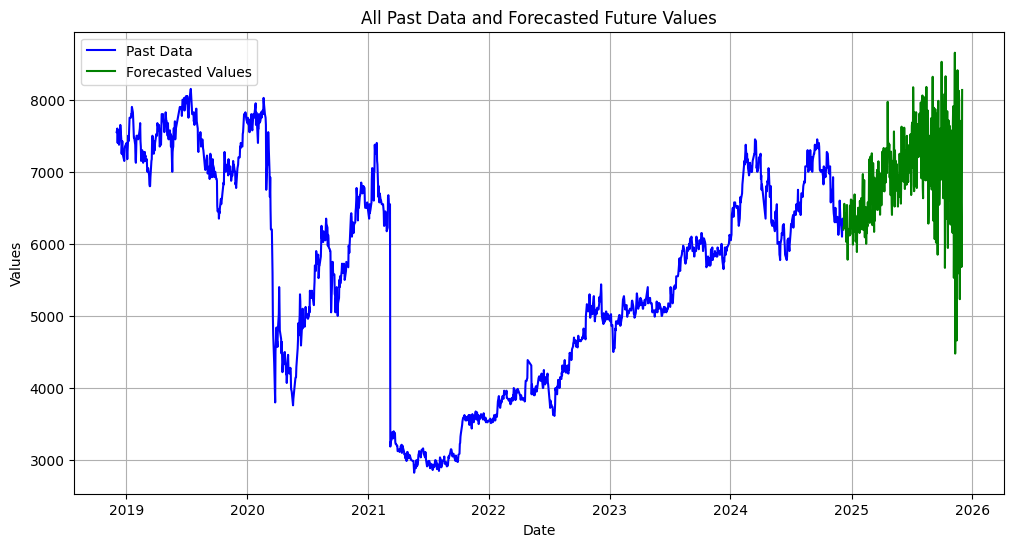

In [23]:
forecasted_values = np.array(forecasted_values).reshape(-1, 1)

dummy_columns = np.zeros((forecasted_values.shape[0], df.shape[1] - 1))
forecasted_values_full = np.hstack([forecasted_values, dummy_columns])

forecasted_values_inverse_full = scaler.inverse_transform(forecasted_values_full)

forecasted_values_inverse = forecasted_values_inverse_full[:, 0]
combined_values = np.concatenate([y_test.values.flatten(), forecasted_values_inverse])


freq = pd.infer_freq(df.index)
time_index = pd.date_range(start=df.index[-1], periods=len(forecasted_values_inverse) + 1, freq=freq)[1:]


plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label="Past Data", linestyle="-", color="blue")
plt.plot(time_index[:len(forecasted_values_inverse)], forecasted_values_inverse, label="Forecasted Values", linestyle="-", color="green")
plt.title("All Past Data and Forecasted Future Values")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()


# Deploy